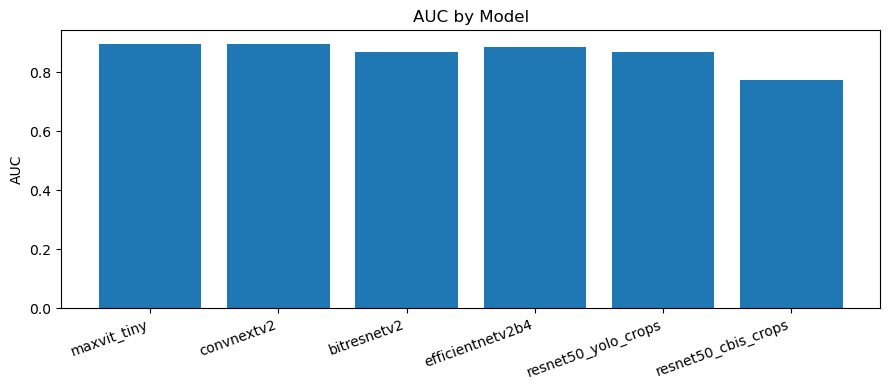

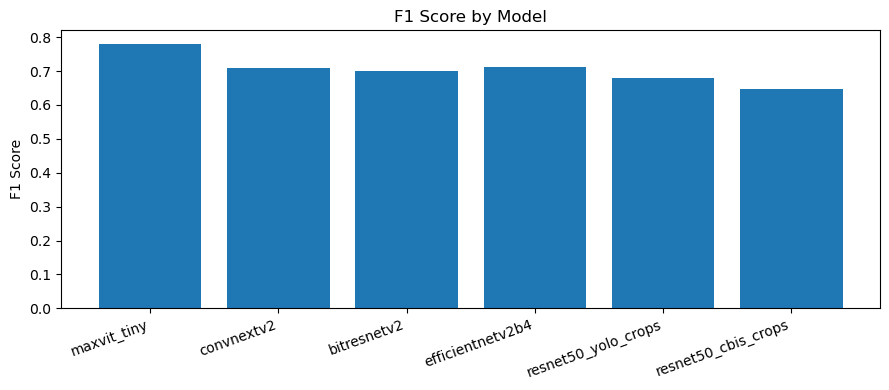

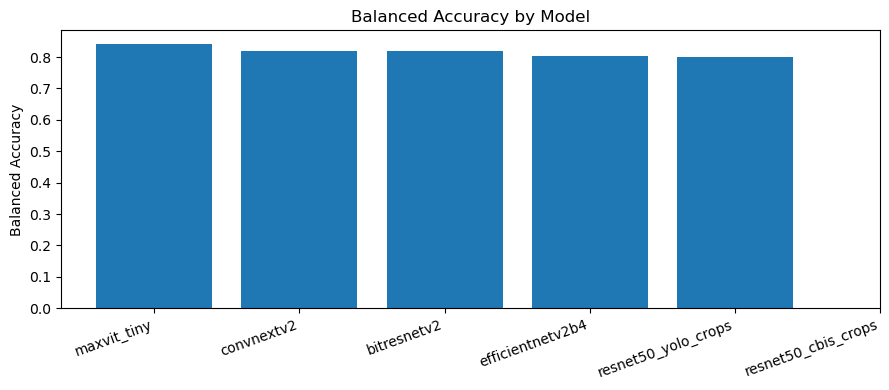

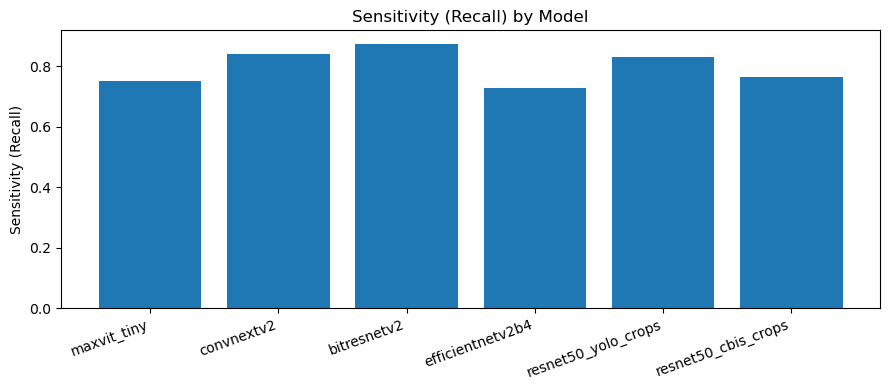

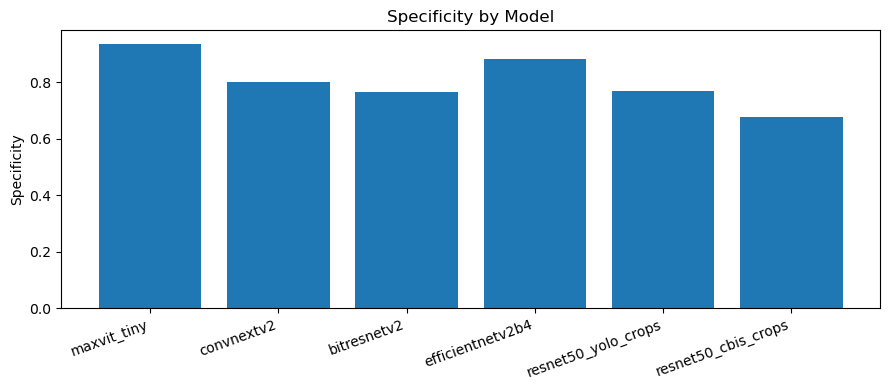

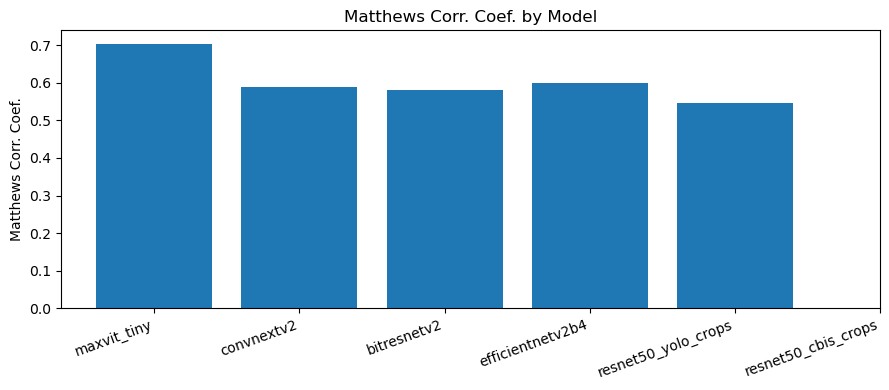

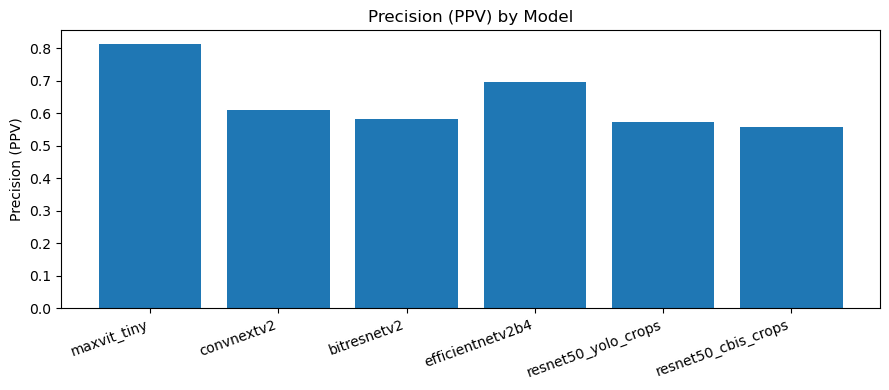

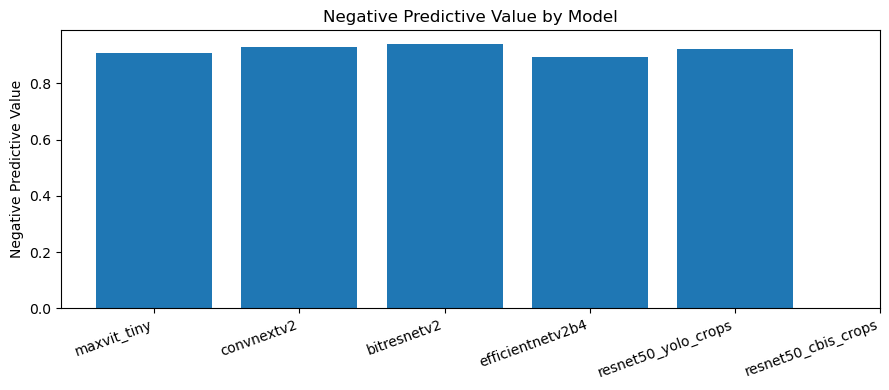

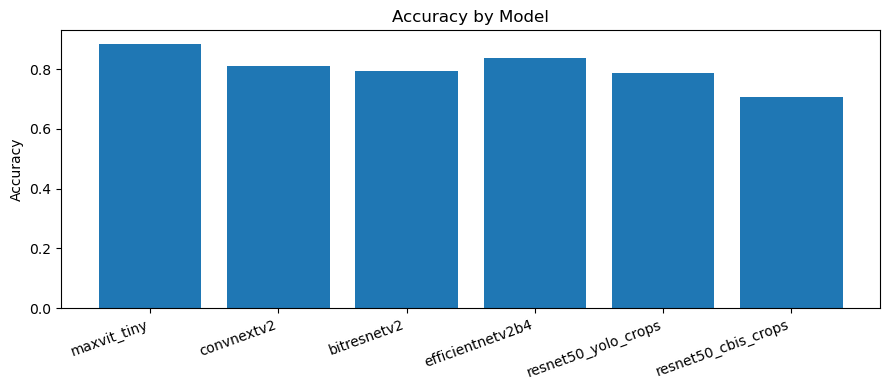

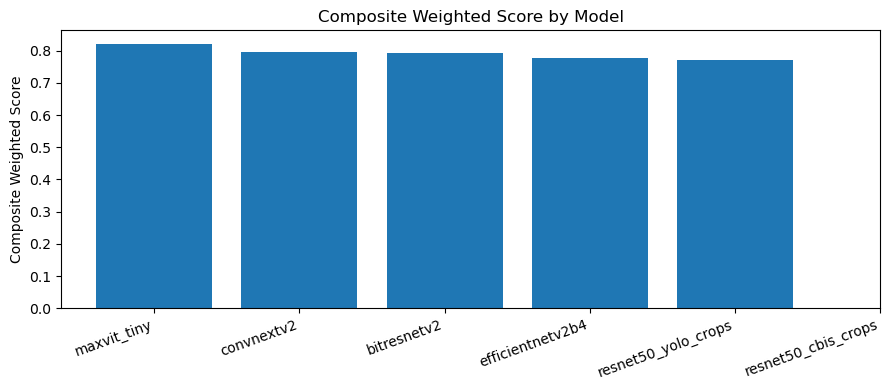

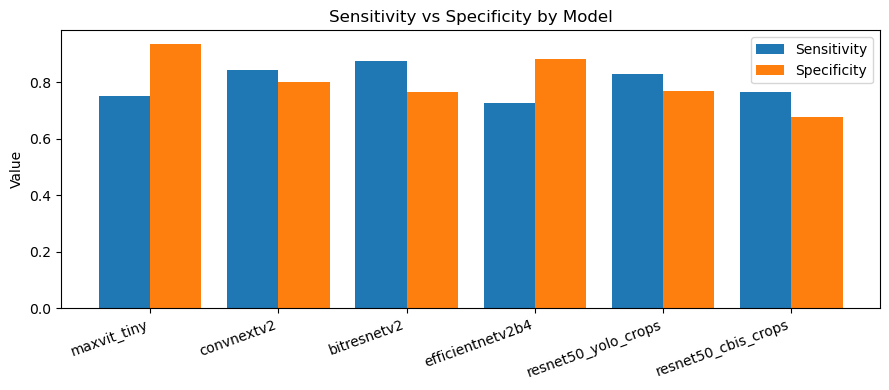

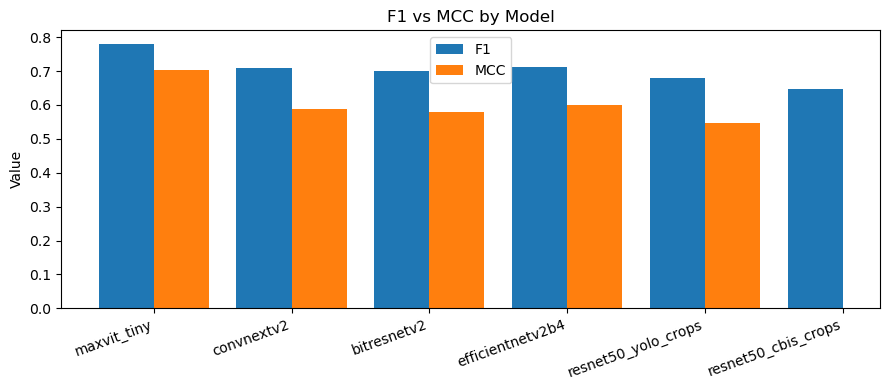

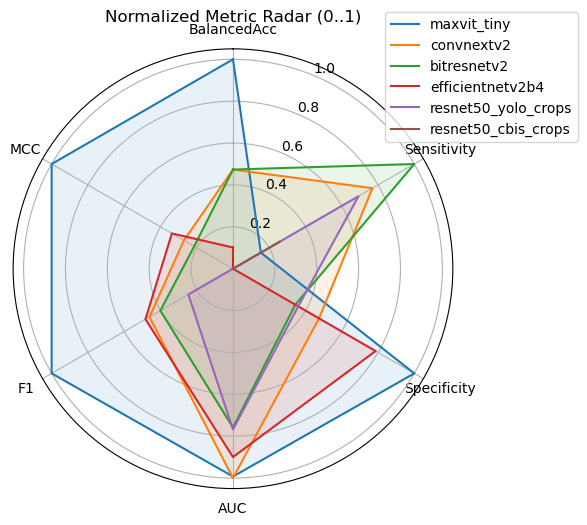

,Model,WeightedScore,BalancedAcc,Sensitivity,Specificity,AUC,F1,MCC
0,maxvit_tiny,0.821998,0.8429,0.7500,0.9359,0.8957,0.7811,0.7045
1,convnextv2,0.795234,0.8200,0.8409,0.7991,0.8966,0.7081,0.5889
2,bitresnetv2,0.791881,0.8200,0.8750,0.7650,0.8670,0.7000,0.5799
3,efficientnetv2b4,0.777110,0.8038,0.7273,0.8803,0.8843,0.7111,0.5994
4,resnet50_yolo_crops,0.771066,0.7994,0.8295,0.7692,0.8681,0.6791,0.5460
5,resnet50_cbis_crops,NaN,NaN,0.7654,0.6755,0.7739,0.6458,NaN


Ranked CSV saved to: C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\data\model_comapre_ranked.csv


In [ ]:
# ============================================
# Visualization & Comparison 
# ============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------- CONFIG ---------
CSV_PATH = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\data\model_comapre.csv"  
SAVE_PDF_REPORT = False  # True = also save PDF report

# Metric weights for composite score
WEIGHTS = {
    "BalancedAcc": 0.20,
    "Sensitivity": 0.25,
    "Specificity": 0.15,
    "AUC": 0.15,
    "F1": 0.10,
    "MCC": 0.10,
    "Precision": 0.03,
    "NPV": 0.02,
    "Accuracy": 0.00,
}

# --------- LOAD & SCORE ---------
df = pd.read_csv(CSV_PATH).copy()
df["WeightedScore"] = 0.0
for metric, w in WEIGHTS.items():
    if metric in df.columns:
        df["WeightedScore"] += df[metric].astype(float) * float(w)

df_ranked = df.sort_values("WeightedScore", ascending=False).reset_index(drop=True)

# --------- HELPER FUNCTIONS ---------
def show_bar(values, labels, title, ylabel, rotate=20):
    x = np.arange(len(labels))
    plt.figure(figsize=(9, 4))
    plt.bar(x, values)
    plt.xticks(x, labels, rotation=rotate, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_grouped(series_dict, labels, title, ylabel, rotate=20):
    names = list(series_dict.keys())
    data = [np.array(series_dict[n]) for n in names]
    n_groups = len(labels)
    n_series = len(names)
    width = 0.8 / n_series
    x = np.arange(n_groups)

    plt.figure(figsize=(9, 4))
    for i, (name, vals) in enumerate(zip(names, data)):
        plt.bar(x + i*width, vals, width=width, label=name)
    plt.xticks(x + (n_series-1)*width/2, labels, rotation=rotate, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def normalize_cols(frame, cols):
    norm = frame.copy()
    for c in cols:
        col = norm[c].astype(float)
        cmin, cmax = col.min(), col.max()
        norm[c] = (col - cmin) / (cmax - cmin) if cmax > cmin else 0.0
    return norm

def show_radar(df_plot, metrics, title):
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    for _, row in df_plot.iterrows():
        vals = [row[m] for m in metrics]
        vals = np.concatenate([vals, vals[:1]])
        ax.plot(angles, vals, label=row["Model"])
        ax.fill(angles, vals, alpha=0.1)

    plt.title(title, pad=20)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# --------- DISPLAY PLOTS ---------
labels = df_ranked["Model"].tolist()

# Single metric bars
for metric, pretty in [
    ("AUC", "AUC"),
    ("F1", "F1 Score"),
    ("BalancedAcc", "Balanced Accuracy"),
    ("Sensitivity", "Sensitivity (Recall)"),
    ("Specificity", "Specificity"),
    ("MCC", "Matthews Corr. Coef."),
    ("Precision", "Precision (PPV)"),
    ("NPV", "Negative Predictive Value"),
    ("Accuracy", "Accuracy"),
    ("WeightedScore", "Composite Weighted Score"),
]:
    if metric in df_ranked.columns:
        vals = df_ranked[metric].astype(float).tolist()
        show_bar(vals, labels, f"{pretty} by Model", pretty)

# Grouped bars
if {"Sensitivity","Specificity"}.issubset(df_ranked.columns):
    show_grouped({"Sensitivity": df_ranked["Sensitivity"], 
                  "Specificity": df_ranked["Specificity"]},
                 labels, "Sensitivity vs Specificity by Model", "Value")

if {"F1","MCC"}.issubset(df_ranked.columns):
    show_grouped({"F1": df_ranked["F1"], "MCC": df_ranked["MCC"]},
                 labels, "F1 vs MCC by Model", "Value")

# Radar chart of normalized key metrics
radar_metrics = ["BalancedAcc","Sensitivity","Specificity","AUC","F1","MCC"]
radar_metrics = [m for m in radar_metrics if m in df_ranked.columns]
if radar_metrics:
    df_norm = normalize_cols(df_ranked[["Model"] + radar_metrics], radar_metrics)
    show_radar(df_norm, radar_metrics, "Normalized Metric Radar (0..1)")

# Show ranked table
display(df_ranked[["Model", "WeightedScore", "BalancedAcc", "Sensitivity", "Specificity", "AUC", "F1", "MCC"]])

# Optionally save ranked CSV
ranked_csv_path = Path(CSV_PATH).with_name(Path(CSV_PATH).stem + "_ranked.csv")
df_ranked.to_csv(ranked_csv_path, index=False)
print(f"Ranked CSV saved to: {ranked_csv_path}")
